## 프로젝트 목표

Instacart 데이터 분석을 통한 주요 상품 파악  
고객 구매 패턴에 따른 마케팅 전략 제시  

+ 문제 정의  
1. 고객이 가장 많이 주문한 상품/상품분류는 무엇일까?  
2. 시간대마다 주로 주문하는 상품/상품분류가 다를까?  
3. 재주문율이 가장 높은 상품/상품분류는 무엇일까?  
4. 장바구니에 담기는 순서가 가장 빠른 상품/상품분류는?  

## Data description

`orders` (3.4m rows, 206k users):
* `order_id`: 주문 id
* `user_id`: 고객 id
* `eval_set`: 대회 모델링 용으로 나누어진 평가 세트
* `order_number`: 해당 사용자의 주문 순서 번호
* `order_dow`: 주문한 요일
* `order_hour_of_day`: 주문이 접수된 시각
* `days_since_prior`: 마지막 주문 이후 경과일수, 최대 30일(order_number가 1인 첫주문인 경우, NaN)

`products` (50k rows):
* `product_id`: 상품 id
* `product_name`: 상품 이름
* `aisle_id`: 진열대 id
* `department_id`: 상품군 id

`aisles` (134 rows):
* `aisle_id`: 진열대 id
* `aisle`: 진열대 이름 (상품군의 소분류. aisle는 하나의 deptartment에 속해있고, deptartments는 여러 aisle을 가진다.)

`deptartments` (21 rows):
* `department_id`: 상품군 id
* `department`: 상품군 이름

`order_products__SET` (30m+ rows):
* `order_id`: 주문 id
* `product_id`: 상품 id
* `add_to_cart_order`: 각 상품이 장바구니에 담긴 순서
* `reordered`: 재주문 이력(주문 한 적 있으면 1, 아니면 0)

## 데이터 불러오기

In [ ]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
order_products_train_df=pd.read_csv("order_products__train.csv")
order_products_prior_df=pd.read_csv("order_products__prior.csv")
orders_df=pd.read_csv("orders.csv")
products_df=pd.read_csv("products.csv")
aisles_df=pd.read_csv("aisles.csv")
departments_df=pd.read_csv("departments.csv")

## 데이터 살펴보기

In [ ]:
order_products_prior_df.info()
order_products_prior_df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 4 columns):
 #   Column             Dtype
---  ------             -----
 0   order_id           int64
 1   product_id         int64
 2   add_to_cart_order  int64
 3   reordered          int64
dtypes: int64(4)
memory usage: 989.8 MB


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
5,2,17794,6,1
6,2,40141,7,1
7,2,1819,8,1
8,2,43668,9,0
9,3,33754,1,1


In [ ]:
order_products_train_df.info()
order_products_train_df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1384617 entries, 0 to 1384616
Data columns (total 4 columns):
 #   Column             Non-Null Count    Dtype
---  ------             --------------    -----
 0   order_id           1384617 non-null  int64
 1   product_id         1384617 non-null  int64
 2   add_to_cart_order  1384617 non-null  int64
 3   reordered          1384617 non-null  int64
dtypes: int64(4)
memory usage: 42.3 MB


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1
5,1,13176,6,0
6,1,47209,7,0
7,1,22035,8,1
8,36,39612,1,0
9,36,19660,2,1


In [ ]:
orders_df.info()
orders_df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3421083 entries, 0 to 3421082
Data columns (total 7 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   user_id                 int64  
 2   eval_set                object 
 3   order_number            int64  
 4   order_dow               int64  
 5   order_hour_of_day       int64  
 6   days_since_prior_order  float64
dtypes: float64(1), int64(5), object(1)
memory usage: 182.7+ MB


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
5,3367565,1,prior,6,2,7,19.0
6,550135,1,prior,7,1,9,20.0
7,3108588,1,prior,8,1,14,14.0
8,2295261,1,prior,9,1,16,0.0
9,2550362,1,prior,10,4,8,30.0


In [ ]:
products_df.info()
products_df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_id     49688 non-null  int64 
 1   product_name   49688 non-null  object
 2   aisle_id       49688 non-null  int64 
 3   department_id  49688 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13
5,6,Dry Nose Oil,11,11
6,7,Pure Coconut Water With Orange,98,7
7,8,Cut Russet Potatoes Steam N' Mash,116,1
8,9,Light Strawberry Blueberry Yogurt,120,16
9,10,Sparkling Orange Juice & Prickly Pear Beverage,115,7


In [ ]:
aisles_df.info()
aisles_df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   aisle_id  134 non-null    int64 
 1   aisle     134 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.2+ KB


,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation
5,6,other
6,7,packaged meat
7,8,bakery desserts
8,9,pasta sauce
9,10,kitchen supplies


In [ ]:
departments_df.info()
departments_df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   department_id  21 non-null     int64 
 1   department     21 non-null     object
dtypes: int64(1), object(1)
memory usage: 464.0+ bytes


,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol
5,6,international
6,7,beverages
7,8,pets
8,9,dry goods pasta
9,10,bulk


## 데이터 전처리

In [ ]:
#결측치 확인
order_products_prior_df.isna().sum()

order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

In [ ]:
order_products_train_df.isna().sum()

order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

In [ ]:
orders_df.isna().sum()

order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

In [ ]:
orders_df.head(20)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
5,3367565,1,prior,6,2,7,19.0
6,550135,1,prior,7,1,9,20.0
7,3108588,1,prior,8,1,14,14.0
8,2295261,1,prior,9,1,16,0.0
9,2550362,1,prior,10,4,8,30.0


In [ ]:
orders_df[orders_df['days_since_prior_order'].isna()]

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
11,2168274,2,prior,1,2,11,NaN
26,1374495,3,prior,1,1,14,NaN
39,3343014,4,prior,1,6,11,NaN
45,2717275,5,prior,1,3,12,NaN
...,...,...,...,...,...,...,...
3420930,969311,206205,prior,1,4,12,NaN
3420934,3189322,206206,prior,1,3,18,NaN
3421002,2166133,206207,prior,1,6,19,NaN
3421019,2227043,206208,prior,1,1,15,NaN


In [ ]:
orders_df[orders_df['days_since_prior_order'].isna()]['order_number'].unique()

array([1], dtype=int64)

order_number가 1인 첫주문에 한해서만 days_since_prior_order가 NaN이므로 해당 데이터들은 -1로 전부 바꿔줍니다.

In [ ]:
orders_df = orders_df.fillna(-1)

In [ ]:
# 중복값 확인
order_products_train_df.duplicated().sum()

0

In [ ]:
order_products_prior_df.duplicated().sum()

0

In [ ]:
orders_df.duplicated().sum()

0

In [ ]:
products_df.duplicated().sum()

0

In [ ]:
aisles_df.duplicated().sum()

0

In [ ]:
departments_df.duplicated().sum()

0

## 데이터 병합

먼저 prior와 train 데이터프레임을 column기준으로 concat해준다

In [ ]:
order_products_df = pd.concat([order_products_prior_df,order_products_train_df],ignore_index=True)
order_products_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33819106 entries, 0 to 33819105
Data columns (total 4 columns):
 #   Column             Dtype
---  ------             -----
 0   order_id           int64
 1   product_id         int64
 2   add_to_cart_order  int64
 3   reordered          int64
dtypes: int64(4)
memory usage: 1.0 GB


In [ ]:
order_products_df.tail()

,order_id,product_id,add_to_cart_order,reordered
33819101,3421063,14233,3,1
33819102,3421063,35548,4,1
33819103,3421070,35951,1,1
33819104,3421070,16953,2,1
33819105,3421070,4724,3,1


In [ ]:
#concat 해준 데이터프레임의 중복값 확인
order_products_df.duplicated().sum()

0

order_products_dfdp 각 id 를 기준으로 상품명, 진열대, 상품군 df를 left join 해준다.

In [ ]:
order_products_df = order_products_df.merge(products_df, on='product_id', how='left').merge( aisles_df, on='aisle_id', how='left').merge(departments_df, on='department_id', how='left')

In [ ]:
#메모리 공간 확보
del order_products_train_df
del order_products_prior_df
del products_df
del aisles_df
del departments_df

In [ ]:
#불필요한 id 컬럼 삭제
order_products_df.drop(['product_id','aisle_id','department_id'], axis=1, inplace=True)

In [ ]:
order_products_df.head()

,order_id,add_to_cart_order,reordered,product_name,aisle,department
0,2,1,1,Organic Egg Whites,eggs,dairy eggs
1,2,2,1,Michigan Organic Kale,fresh vegetables,produce
2,2,3,0,Garlic Powder,spices seasonings,pantry
3,2,4,1,Coconut Butter,oils vinegars,pantry
4,2,5,0,Natural Sweetener,baking ingredients,pantry


In [ ]:
#prior와 train 데이터만 남긴다.
orders_df = orders_df[(orders_df['eval_set']=='prior') | (orders_df['eval_set']=='train')].drop(['eval_set'], axis=1)

In [ ]:
order_products_df = order_products_df.merge(orders_df, on='order_id', how='left')
order_products_df

,order_id,add_to_cart_order,reordered,product_name,aisle,department,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,1,1,Organic Egg Whites,eggs,dairy eggs,202279,3,5,9,8.0
1,2,2,1,Michigan Organic Kale,fresh vegetables,produce,202279,3,5,9,8.0
2,2,3,0,Garlic Powder,spices seasonings,pantry,202279,3,5,9,8.0
3,2,4,1,Coconut Butter,oils vinegars,pantry,202279,3,5,9,8.0
4,2,5,0,Natural Sweetener,baking ingredients,pantry,202279,3,5,9,8.0
...,...,...,...,...,...,...,...,...,...,...,...
33819101,3421063,3,1,Natural Artesian Water,water seltzer sparkling water,beverages,169679,30,0,10,4.0
33819102,3421063,4,1,Twice Baked Potatoes,prepared meals,deli,169679,30,0,10,4.0
33819103,3421070,1,1,Organic Unsweetened Almond Milk,soy lactosefree,dairy eggs,139822,15,6,10,8.0
33819104,3421070,2,1,Creamy Peanut Butter,spreads,pantry,139822,15,6,10,8.0


## 데이터 분석

In [ ]:
orders_df.user_id.nunique()

206209

+ 데이터 구성  
총 206,209명의 고객의 3,346,083건에 대한 주문 정보  
총 주문 상품 : 33,819,105  
상품종류: 49,688  
진열대 분류: 134  
상품분류: 21  

Q1  
가장 많이 주문한 상품/상품분류는?

In [ ]:
tmp = order_products_df.groupby('product_name',as_index=False).count()
tmp =tmp.sort_values(by = 'order_id' , ascending=False).head(15)[['product_name','order_id']]
tmp

,product_name,order_id
3677,Banana,491291
3472,Bag of Organic Bananas,394930
31923,Organic Strawberries,275577
28843,Organic Baby Spinach,251705
30300,Organic Hass Avocado,220877
28807,Organic Avocado,184224
22415,Large Lemon,160792
42908,Strawberries,149445
23422,Limes,146660
32481,Organic Whole Milk,142813


In [ ]:
#시각화
fig = px.bar(tmp, x='product_name', y='order_id',
             labels={'product_name':'product name','order_id':'number of orders'}
             ,text='order_id', title='Number of orders by product')
fig.update_traces(texttemplate='%{text:.3s}', textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.show()

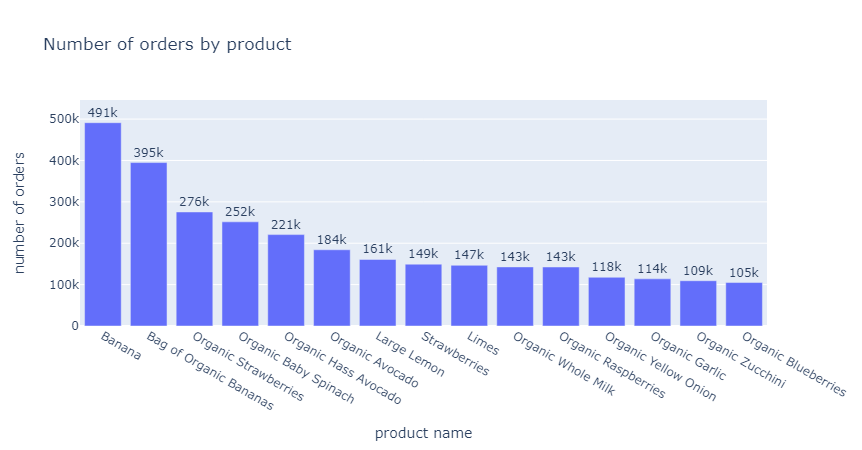

단일 품목으로는 바나나가 가장 많이 팔렸다.  
Banana 상품과 Bag of Organic Bananas 상품을 합치면 전체 주문(33.5M)의 2.6% 정도의 높은 비중을 차지한다.
그 외 순위권에 드는 상품들을 살펴보면 과일이나 야채종류가 많다.  
그리고 Organic(유기농) 상품들의 순위가 높은것을 확인 할 수 있다.  

In [ ]:
# 가장 많이 판매되는 진열대 품목 확인
tmp = order_products_df.groupby('aisle',as_index=False).count().sort_values(by = 'order_id' , ascending=False).head(15)[['aisle','order_id']]
fig = px.bar(tmp, x='aisle', y='order_id',
             labels={'order_id':'number of orders'}
             ,text='order_id' ,title='Number of orders by aisle')
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.show()

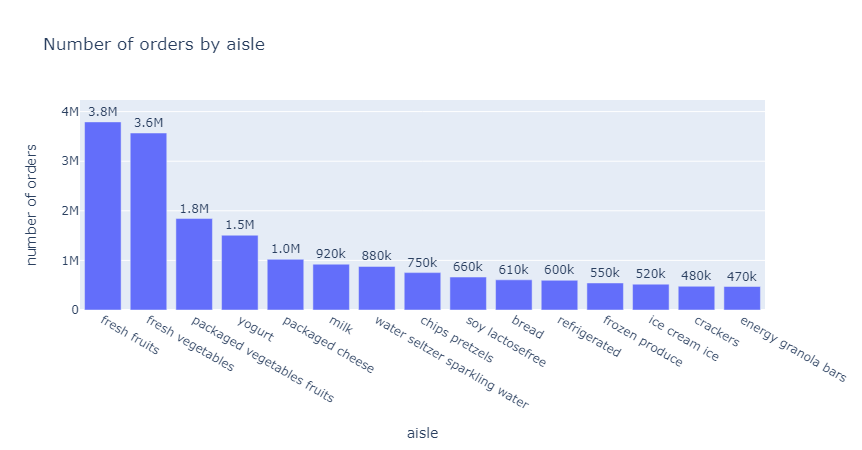

진열대(소분류)별 주문량에서는 신선 과일과 신선 채소가 높은 비중을 차지하였다.  
3등도 포장된 채소, 과일이므로 1~3위를 합쳐 전체 주문(33.5M)의 25% 가량을 야채와 과일이 차지하는 것을 확인 할 수 있다.

In [ ]:
#파이차트로 다시 확인해보자
tmp = order_products_df.groupby('aisle',as_index=False).count().sort_values(by = 'order_id' , ascending=False)[['aisle','order_id']]
tmp.loc[tmp['order_id'] < 400e03, 'aisle']  ='Etc' # 모든항목을 표시할수 없으므로 400k보다 주문량이 적으면 Etc로 표기
fig = px.pie(tmp, values='order_id', names='aisle', title='Number of orders by aisle')
fig.show()

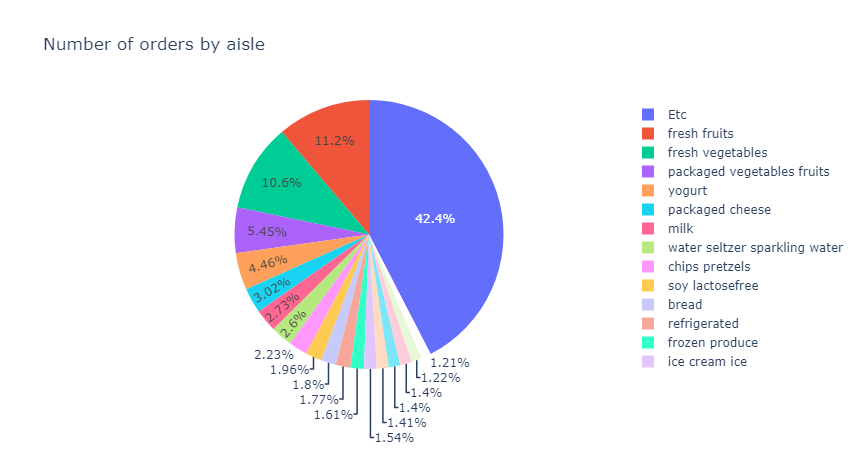

In [ ]:
#상품군 확인
tmp = order_products_df.groupby('department',as_index=False).count().sort_values(by = 'order_id' , ascending=False).head(15)[['department','order_id']]
fig = px.bar(tmp, x='department', y='order_id',
             labels={'order_id':'number of orders'} ,text='order_id', title='Number of orders by department')
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.show()

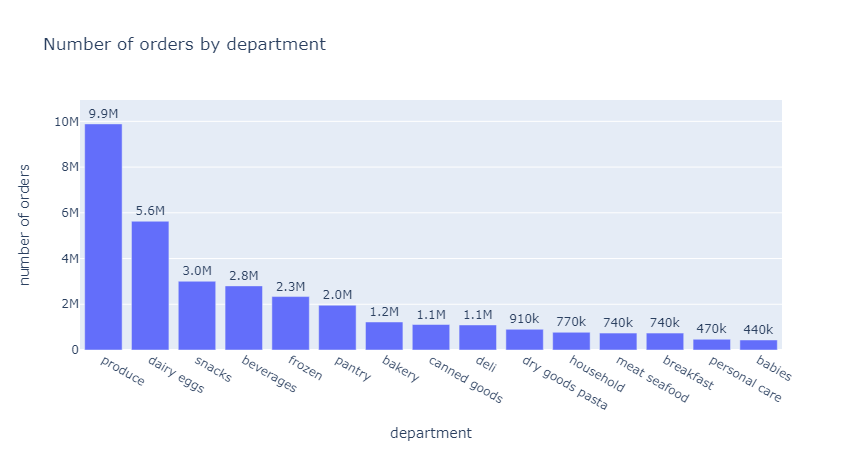

상품군별 주문량을 살펴보면  
생산품(농작물) 분류가 가장 높고, 그 뒤로 유제품&계란, 스낵, 음료, 냉동식품 순으로 높은 비중을 차지했다.

Q2  
시간대마다 주로 주문하는 상품/상품분류가 다른가?

In [ ]:
#시간대별 주문수를 먼저 알아보자
tmp = orders_df.groupby('order_hour_of_day',as_index=False).count()
fig = px.bar(tmp, x='order_hour_of_day', y='order_id',
             labels={'order_id':'number of orders', 'order_hour_of_day':'hour'} ,text='order_id', title='Number of orders by hour of day')
fig.update_traces(texttemplate='%{text:.3s}', textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.show()

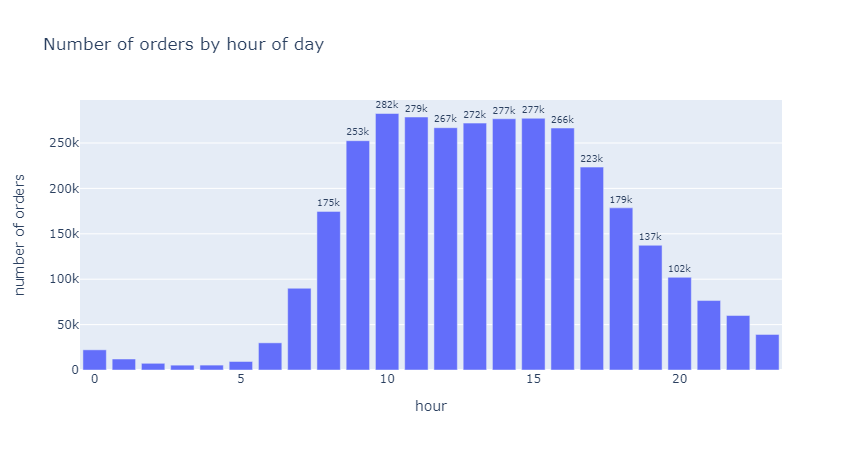

오전 8시에서 오후 6시 사이에 대부분의 주문이 이뤄지는 것을 확인했다.

In [ ]:
# 시간별로 주문되는 주요상품 확인
tmp = order_products_df.groupby(['product_name','order_hour_of_day'], as_index=False).agg({'order_id':len})

top10 = []
for i in range(24):
    top10_list = tmp[tmp['order_hour_of_day'] == i].nlargest(20,'order_id', keep='all')['product_name'].iloc[:10].tolist()
    top10.append(top10_list)
top10_df = pd.DataFrame(top10)
top10_df.columns=['rank1','rank2','rank3','rank4','rank5','rank6','rank7','rank8','rank9','rank10']
top10_df.T

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
rank1,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,...,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana
rank2,Bag of Organic Bananas,Bag of Organic Bananas,Bag of Organic Bananas,Bag of Organic Bananas,Bag of Organic Bananas,Bag of Organic Bananas,Bag of Organic Bananas,Bag of Organic Bananas,Bag of Organic Bananas,Bag of Organic Bananas,...,Bag of Organic Bananas,Bag of Organic Bananas,Bag of Organic Bananas,Bag of Organic Bananas,Bag of Organic Bananas,Bag of Organic Bananas,Bag of Organic Bananas,Bag of Organic Bananas,Bag of Organic Bananas,Bag of Organic Bananas
rank3,Organic Strawberries,Organic Baby Spinach,Organic Baby Spinach,Organic Baby Spinach,Organic Baby Spinach,Organic Strawberries,Organic Strawberries,Organic Strawberries,Organic Strawberries,Organic Strawberries,...,Organic Strawberries,Organic Strawberries,Organic Strawberries,Organic Strawberries,Organic Strawberries,Organic Strawberries,Organic Strawberries,Organic Strawberries,Organic Strawberries,Organic Strawberries
rank4,Organic Baby Spinach,Organic Strawberries,Organic Strawberries,Organic Strawberries,Organic Strawberries,Organic Baby Spinach,Organic Baby Spinach,Organic Baby Spinach,Organic Baby Spinach,Organic Baby Spinach,...,Organic Baby Spinach,Organic Baby Spinach,Organic Baby Spinach,Organic Baby Spinach,Organic Baby Spinach,Organic Baby Spinach,Organic Baby Spinach,Organic Baby Spinach,Organic Baby Spinach,Organic Baby Spinach
rank5,Organic Hass Avocado,Organic Hass Avocado,Organic Hass Avocado,Organic Hass Avocado,Organic Hass Avocado,Organic Hass Avocado,Organic Hass Avocado,Organic Hass Avocado,Organic Hass Avocado,Organic Hass Avocado,...,Organic Hass Avocado,Organic Hass Avocado,Organic Hass Avocado,Organic Hass Avocado,Organic Hass Avocado,Organic Hass Avocado,Organic Hass Avocado,Organic Hass Avocado,Organic Hass Avocado,Organic Hass Avocado
rank6,Organic Avocado,Organic Avocado,Organic Avocado,Organic Avocado,Large Lemon,Strawberries,Organic Whole Milk,Organic Whole Milk,Organic Avocado,Organic Avocado,...,Organic Avocado,Organic Avocado,Organic Avocado,Organic Avocado,Organic Avocado,Organic Avocado,Organic Avocado,Organic Avocado,Organic Avocado,Organic Avocado
rank7,Large Lemon,Large Lemon,Large Lemon,Large Lemon,Organic Avocado,Large Lemon,Organic Avocado,Organic Avocado,Organic Whole Milk,Strawberries,...,Large Lemon,Large Lemon,Large Lemon,Large Lemon,Large Lemon,Large Lemon,Organic Whole Milk,Organic Whole Milk,Organic Whole Milk,Strawberries
rank8,Limes,Limes,Strawberries,Limes,Strawberries,Organic Avocado,Strawberries,Organic Raspberries,Organic Raspberries,Large Lemon,...,Limes,Limes,Limes,Limes,Strawberries,Strawberries,Organic Raspberries,Organic Raspberries,Organic Raspberries,Large Lemon
rank9,Strawberries,Strawberries,Limes,Strawberries,Limes,Organic Raspberries,Organic Raspberries,Strawberries,Strawberries,Organic Raspberries,...,Strawberries,Strawberries,Strawberries,Strawberries,Limes,Organic Raspberries,Strawberries,Large Lemon,Large Lemon,Organic Raspberries
rank10,Organic Raspberries,Organic Raspberries,Organic Raspberries,Organic Garlic,Organic Raspberries,Organic Whole Milk,Large Lemon,Large Lemon,Large Lemon,Organic Whole Milk,...,Organic Whole Milk,Organic Whole Milk,Organic Raspberries,Organic Raspberries,Organic Raspberries,Organic Whole Milk,Large Lemon,Strawberries,Strawberries,Organic Whole Milk


시간대 마다 일부 상품의 주문순위가 바뀌긴 하나, 대부분 과일 채소류여서 특정 시간에 우세한 상품을 확인할 수는 없었다. 상품 분류별로 확인하는것이 더 분석에 용이할 것 같다.

In [ ]:
#시간별 진열대 분류도 확인
tmp = order_products_df.groupby(['aisle','order_hour_of_day'], as_index=False).agg({'order_id':len})

top10 = []
for i in range(24):
    top10_list = tmp[tmp['order_hour_of_day'] == i].nlargest(10,'order_id', keep='all')['aisle'].iloc[:10].tolist()
    top10.append(top10_list)
top10_df = pd.DataFrame(top10)
top10_df.columns=['rank1','rank2','rank3','rank4','rank5','rank6','rank7','rank8','rank9','rank10']
top10_df.T

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
rank1,fresh vegetables,fresh vegetables,fresh vegetables,fresh vegetables,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,...,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits
rank2,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh vegetables,fresh vegetables,fresh vegetables,fresh vegetables,fresh vegetables,fresh vegetables,...,fresh vegetables,fresh vegetables,fresh vegetables,fresh vegetables,fresh vegetables,fresh vegetables,fresh vegetables,fresh vegetables,fresh vegetables,fresh vegetables
rank3,packaged vegetables fruits,packaged vegetables fruits,packaged vegetables fruits,packaged vegetables fruits,packaged vegetables fruits,packaged vegetables fruits,packaged vegetables fruits,packaged vegetables fruits,packaged vegetables fruits,packaged vegetables fruits,...,packaged vegetables fruits,packaged vegetables fruits,packaged vegetables fruits,packaged vegetables fruits,packaged vegetables fruits,packaged vegetables fruits,packaged vegetables fruits,packaged vegetables fruits,packaged vegetables fruits,packaged vegetables fruits
rank4,yogurt,yogurt,yogurt,yogurt,yogurt,yogurt,yogurt,yogurt,yogurt,yogurt,...,yogurt,yogurt,yogurt,yogurt,yogurt,yogurt,yogurt,yogurt,yogurt,yogurt
rank5,packaged cheese,packaged cheese,packaged cheese,packaged cheese,packaged cheese,packaged cheese,milk,milk,milk,milk,...,packaged cheese,packaged cheese,packaged cheese,packaged cheese,packaged cheese,packaged cheese,packaged cheese,packaged cheese,packaged cheese,packaged cheese
rank6,milk,water seltzer sparkling water,water seltzer sparkling water,water seltzer sparkling water,water seltzer sparkling water,milk,packaged cheese,packaged cheese,packaged cheese,packaged cheese,...,milk,milk,milk,water seltzer sparkling water,milk,milk,milk,milk,milk,milk
rank7,water seltzer sparkling water,milk,milk,milk,milk,water seltzer sparkling water,water seltzer sparkling water,water seltzer sparkling water,water seltzer sparkling water,water seltzer sparkling water,...,water seltzer sparkling water,water seltzer sparkling water,water seltzer sparkling water,milk,water seltzer sparkling water,water seltzer sparkling water,water seltzer sparkling water,water seltzer sparkling water,water seltzer sparkling water,water seltzer sparkling water
rank8,soy lactosefree,refrigerated,refrigerated,refrigerated,refrigerated,refrigerated,soy lactosefree,soy lactosefree,chips pretzels,chips pretzels,...,chips pretzels,chips pretzels,chips pretzels,chips pretzels,chips pretzels,chips pretzels,chips pretzels,soy lactosefree,soy lactosefree,chips pretzels
rank9,chips pretzels,soy lactosefree,soy lactosefree,chips pretzels,soy lactosefree,soy lactosefree,bread,bread,soy lactosefree,soy lactosefree,...,soy lactosefree,soy lactosefree,soy lactosefree,soy lactosefree,ice cream ice,ice cream ice,soy lactosefree,chips pretzels,chips pretzels,soy lactosefree
rank10,refrigerated,chips pretzels,chips pretzels,soy lactosefree,chips pretzels,chips pretzels,chips pretzels,chips pretzels,bread,bread,...,bread,bread,bread,ice cream ice,soy lactosefree,soy lactosefree,ice cream ice,frozen produce,frozen produce,frozen produce


In [ ]:
# 시각화 하여 확인
tmp = order_products_df.groupby(['aisle','order_hour_of_day'], as_index=False).agg({'order_id':len})
concat_list = []
for (key, rows) in tmp.groupby('order_hour_of_day'):
    sub_ds = rows.sort_values('order_id', ascending=False)[:10]
    sub_ds['rank'] = list(range(1,11))
    concat_list.append(sub_ds)

tmp = pd.concat(concat_list)
tmp = tmp.pivot(index='order_hour_of_day', columns='aisle', values='rank')

In [ ]:
fig= px.line(tmp,  title='Number of orders by hour of day')
fig.update_layout(
    yaxis = dict(autorange='reversed', dtick = 1),
    xaxis = dict(dtick = 1),
    yaxis_title="rank",
    )
fig.show()

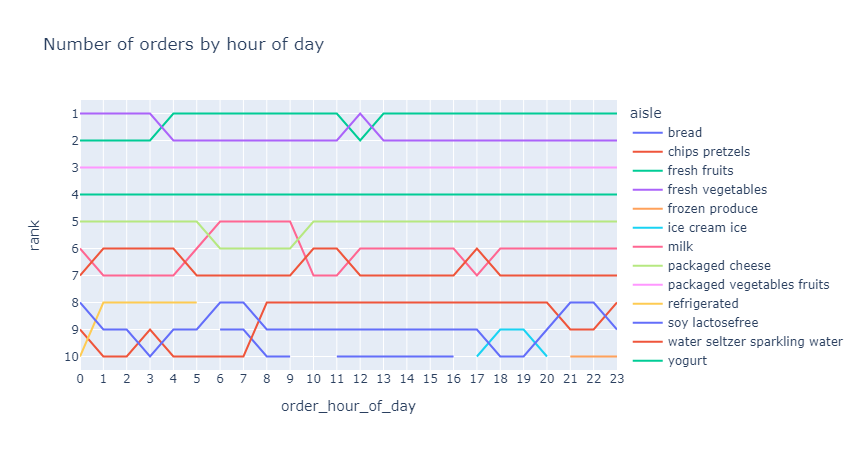

신선 과일의 주문량이 가장 많지만 낮 12시에는 신선 채소의 주문량이 많아진다.  
아침 6&#126;9시에 우유의 주문량이 늘어나는 것을 확인할 수 있다.  
21시에서 24시까지는 냉동제품이, 0시에서 5시까지는 냉장제품 진열대의 주문량이 평소보다 높다.  
6&#126;9시, 11&#126;16시에 빵의 주문량이 늘어난다.  

해당시간에 인스타카트의 메인페이지에 해당 aisle의 상품들을 더 노출시키면 클릭률을 더 높일 수 있다.

In [ ]:
# 시간별 department 주문량 시각화
tmp = order_products_df.groupby(['department','order_hour_of_day'], as_index=False).agg({'order_id':len})
concat_list = []
for (key, rows) in tmp.groupby('order_hour_of_day'):
    sub_ds = rows.sort_values('order_id', ascending=False)[:10]
    sub_ds['rank'] = list(range(1,11))
    concat_list.append(sub_ds)

tmp = pd.concat(concat_list)
tmp = tmp.pivot(index='order_hour_of_day', columns='department', values='rank')

In [ ]:
fig= px.line(tmp)
fig.update_layout(
    yaxis = dict(autorange='reversed', dtick = 1),
    xaxis = dict(dtick = 1),
    yaxis_title="rank",
    )
fig.show()

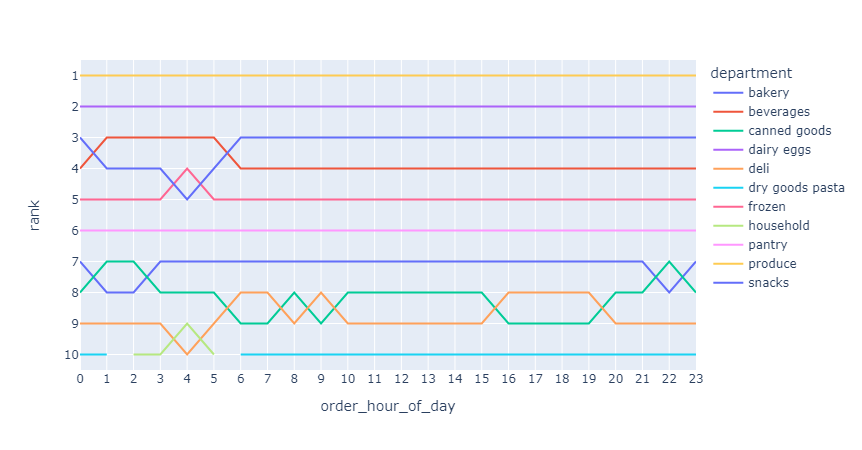

department는 큰 단위의 상품 분류여서, 시간에 따른 주문량 변화에서 인사이트를 도출하기 힘들 것 같다.

Q3  
재주문율이 가장 높은 상품/상품분류는?

In [ ]:
tmp = order_products_df.groupby(['product_name'], as_index=False).agg({'order_id':'count', 'reordered':'mean'})
tmp = tmp.sort_values('reordered', ascending=False)
tmp.columns = ['product_name','order_count','reorder_rate']
# 주문횟수가 500회 이하인 제품들은 제외하고 분석
tmp = tmp[tmp['order_count']>500]
tmp.head(20)

,product_name,order_count,reorder_rate
19078,Half And Half Ultra Pasteurized,2995,0.861436
48793,Whole Organic Omega 3 Milk,9410,0.859830
30559,Organic Lactose Free Whole Milk,8742,0.859186
30365,Organic Homogenized Whole Milk,4095,0.858120
46502,Ultra-Purified Water,1524,0.856955
25591,"Milk, Organic, Vitamin D",20770,0.854742
31481,Organic Reduced Fat Milk,36869,0.851501
17777,Goat Milk,5353,0.850177
3677,Banana,491291,0.845051
30699,Organic Lowfat 1% Milk,15352,0.841193


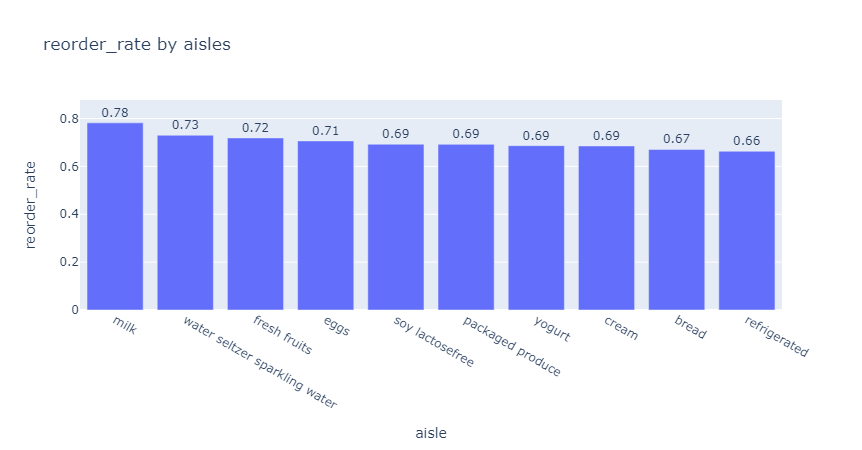

다양한 우유들의 재주문율이 높게 나온것을 확인할 수 있었다.  
대부분의 고객들이 원래 마시던 우유제품를 재주문 할 가능성이 매우 높다고 할 수 있다.  

In [ ]:
# aisle 분류의 재주문율도 확인해보자
tmp = order_products_df.groupby(['aisle'], as_index=False).agg({'order_id':'count', 'reordered':'mean'})
tmp = tmp.sort_values('reordered', ascending=False)
tmp.columns = ['aisle', 'order_count','reorder_rate']
tmp = tmp[tmp['order_count']>500]
tmp.head(20)

,aisle,order_count,reorder_rate
83,milk,923659,0.781812
131,water seltzer sparkling water,878150,0.729930
50,fresh fruits,3792661,0.718823
41,eggs,472009,0.706359
119,soy lactosefree,664493,0.692361
96,packaged produce,289488,0.691977
133,yogurt,1507583,0.686501
33,cream,330358,0.685184
11,bread,608469,0.670552
110,refrigerated,599109,0.663006


In [ ]:
fig = px.bar(tmp.head(10), x='aisle', y='reorder_rate'
             ,text='reorder_rate'
             ,title='reorder_rate by aisles')
fig.update_traces(texttemplate='%{text:.2}', textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.show()

역시나 우유의 재주문율이 눈에 띄게 높은것을 확인 할 수 있었다.

그렇다면 고객들은 재주문율이 높은 상품들을 평균적으로 몇 일마다 재구매할까? 확인해보자

In [ ]:
#1위 우유
tmp = order_products_df.query('(aisle=="milk") and (days_since_prior_order>0)')
tmp.days_since_prior_order.mean()

10.784601852270894

In [ ]:
#2위 water seltzer sparkling water
tmp = order_products_df.query('(aisle=="water seltzer sparkling water") and (days_since_prior_order>0)')
tmp.days_since_prior_order.mean()

11.590479639564434

In [ ]:
#3위 fresh fruits
tmp = order_products_df.query('(aisle=="fresh fruits") and (days_since_prior_order>0)')
tmp.days_since_prior_order.mean()

10.906245099637745

우유, 물, 과일 모두 평균적으로  구매한지 10~11일 정도 후에 재주문을 하는것으로 나타났다.  
우유, 물, 과일을 구매한지 7일이 넘은 고객들에게 이전에 구매한것과 동일한 제품을 추천한다면 주문하거나 장바구니에 담을 가능성이 높을것이라 기대할 수 있다.

Q4  
장바구니에 담기는 순서가 가장 빠른 상품/상품분류는?

In [ ]:
#주문당 장바구니에 담는 개수의 평균은?
order_products_df['add_to_cart_order'].mean()

8.367737574139305

In [ ]:
tmp = order_products_df.groupby('product_name',as_index=False).agg({'order_id':'count','add_to_cart_order':'mean'})
tmp = tmp.sort_values(by = 'add_to_cart_order')[['product_name','order_id','add_to_cart_order']]
tmp.columns=['product_name','order_count','add_to_cart_order(mean)']
# 주문횟수가 500회 이하인 제품들은 제외하고 분석
tmp = tmp[tmp['order_count']>500]
tmp.head(20)

,product_name,order_count,add_to_cart_order(mean)
48016,Water Mineral,2282,2.709465
25827,Minis to Go Natural Spring Water,639,2.798122
41897,"Sparkling Water, Bottles",1625,2.887385
30677,Organic Low Fat Milk,8806,2.891551
42311,Sport Bottle with Flip Cap Natural Spring Water,516,3.000000
46173,USDA AA Extra Large Eggs,2287,3.004810
638,2% Lactose Free Milk,1854,3.086839
49208,XL Pick-A-Size Paper Towel Rolls,1319,3.088704
39769,Seltzer Water,1982,3.115540
48434,White Multifold Towels,1590,3.145912


In [ ]:
fig = px.bar(tmp.head(10), x='product_name', y='add_to_cart_order(mean)',
             color='order_count',color_continuous_scale='Bluered', text='add_to_cart_order(mean)')
fig.update_traces(texttemplate='%{text:.3s}', textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.show()

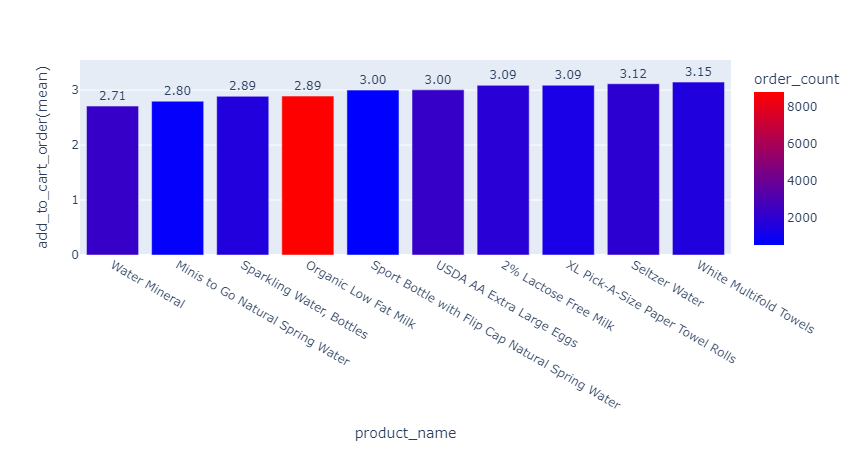

상품별 장바구니 순서는 물 종류가 평균적으로 빠르게 담기는 것으로 확인 되었다.  
물 외에도 우유나 콜라 등의 음료종류가 많이 보인다.

In [ ]:
tmp = order_products_df.groupby('aisle',as_index=False).agg({'order_id':'count','add_to_cart_order':'mean'})
tmp = tmp.sort_values(by = 'add_to_cart_order')[['aisle','order_id','add_to_cart_order']]
tmp.columns=['aisle','order_count','add_to_cart_order(mean)']
tmp.head(20)

,aisle,order_count,add_to_cart_order(mean)
123,spirits,29069,4.853349
96,packaged produce,289488,5.141712
121,specialty wines champagnes,11659,5.213740
9,beers coolers,50496,5.352127
83,milk,923659,5.576440
132,white wines,31646,5.598464
109,red wines,36424,5.947095
131,water seltzer sparkling water,878150,6.086957
41,eggs,472009,6.435782
117,soft drinks,373816,6.469137


In [ ]:
fig = px.bar(tmp.head(10), x='aisle', y='add_to_cart_order(mean)',
             color='order_count',color_continuous_scale='Bluered' , text='add_to_cart_order(mean)'
            )
fig.update_traces(texttemplate='%{text:.3s}', textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.show()

상품별 장바구니에 담기는 순서와는 조금 다른 결과가 나왔다.  
하지만 증류주, 맥주, 샴페인, 와인, 우유, 물, 두유, 각종 드링크 등, 주류/음료류가 상위권을 자치하고 있는것을 확인 할 수 있다.

현재 장바구니가 비어있는 고객의 경우, 주류/음료류를 권하는 것이 좋을 것 같다.

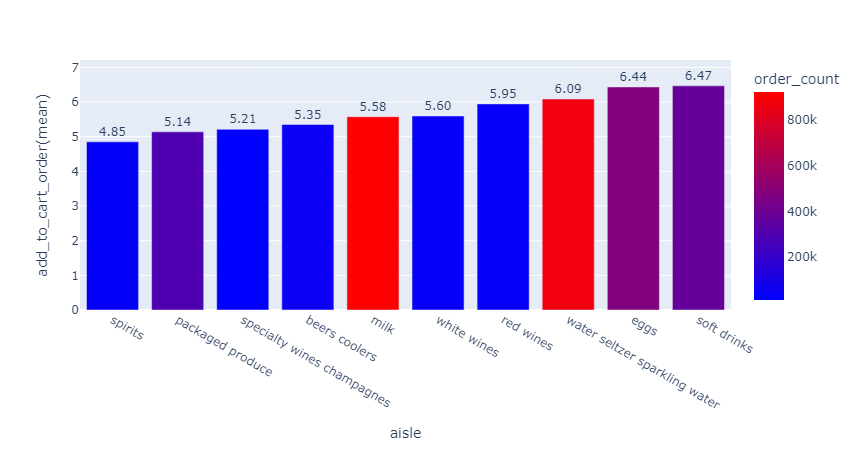

Q5 추가 질문  
유기농 상품의 주문 비율은 어느정도 될까?

In [ ]:
tmp = order_products_df[order_products_df['product_name'].str.contains('Organic')]

In [ ]:
len(tmp)/len(order_products_df)

0.31508780864875613

유기농 상품의 비율은 31.5%